## Descripción de las variables del dataset de partidos del Futbol Argentino 2015-2022

Este dataset contiene la información de 2821 partidos de primera división del fútbol argentino agrupando datos de promiedos.com.ar, transfermarkt.de y oddportal.com en el archivo afa_2015_2022_spa.csv:

* torneo: nombre del torneo en curso cuando se jugó el partido. promiedos
* fecha: en qué fecha se jugó el partido. promiedos.
* partido: número de partido dentro de la fecha. promiedos.
* equipo_local(visitante): nombre del equipo local(visitante) promiedos.
* goles_local(visitante): número de goles anotados por el equipo local(visitante). promiedos.
* goles_visitante(visitante): porcentaje de posesión del equipo local(visitante). promiedos.
* tiros_arco_local(visitante): tiros al arco del equipo local(visitante). promiedos.
* intentos_local(visitante): intentos totales del equipo local(visitante). promiedos.
* faltas_local(visitante): faltas cometidas por el equipo local(visitante). promiedos.
* tiros_esquina_local(visitante): tiros de esquina realizados por el equipo local(visitante). promiedos.
* amarillas_local(visitante): tarjetas amarillas del equipo local(visitante). promiedos.
* rojas_local(visitante): tarjetas rojas del equipo local(visitante). promiedos.
* valor_mercado_local(visitante): valor de mercado según del equipo local(visitante). transfermarkt.
* altura_media_local(visitante): altura media del equipo local(visitante). transfermarkt.
* edad_media_local(visitante): edad media del equipo local(visitante). transfermarkt.
* proporcion_zurdos_local(visitante): proporcion de jugadores zurdos en el equipo local (visitante). transfermarkt.
* resultado: resultado del encuentro.
* fecha_encuentro: fecha del encuentro. oddsportal.
* apuesta_local(visitante): retorno de apuesta para una victoria del equipo local(visitante). oddsportal.
* apuesta_empate: retorno de apuesta para un empate. oddsportal.

Los nombres de los equipos y de los torneos son los que se encuentran en promiedos.com.ar

## Importación de librerías esenciales

In [2]:
#Importación de librerías esenciales para el análisis exploratorio de datos (EDA)

# Pandas: Herramienta principal para la manipulación y estructuración de dataframes
import pandas as pd
# Numpy: Soporte para operaciones matemáticas avanzadas y manejo de estructuras vectoriales
import numpy as np
# Seaborn: Biblioteca de alto nivel para la creación de gráficos estadísticos atractivos
import seaborn as sns
# Statsmodels: Implementación de modelos estadísticos y pruebas de hipótesis mediante fórmulas
import statsmodels.formula.api as smf
# Matplotlib: Motor base de visualización para personalizar detalles específicos de los gráficos
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Datetime: Gestión y manipulación de variables temporales (fechas y horas)
from datetime import datetime, date
# Creación de componentes de interfaz de usuario para análisis interactivo
import ipywidgets as widgets
from IPython.display import display
# Scipy Stats: Funciones estadísticas para validación de correlaciones y distribuciones
import scipy.stats as stats

# Configuraciones para mayor legibilidad y estética.
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
plt.style.use("ggplot")

In [3]:
# Importamos el dataset desde kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter
df_arg = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "camussonif/argentinian-football-results-20152022",
  "afa_2015_2022_spa.csv")

Using Colab cache for faster access to the 'argentinian-football-results-20152022' dataset.




---



### Verificación Inicial de Integridad Estructural

In [4]:
# Validar que el dataset no esté corrupto.
df_arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821 entries, 0 to 2820
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   torneo                       2821 non-null   object 
 1   fecha                        2821 non-null   int64  
 2   partido                      2821 non-null   int64  
 3   equipo_local                 2821 non-null   object 
 4   equipo_visitante             2821 non-null   object 
 5   goles_local                  2821 non-null   int64  
 6   goles_visitante              2821 non-null   int64  
 7   posesion_local               1496 non-null   float64
 8   tiros_arco_local             1496 non-null   float64
 9   intentos_local               1496 non-null   float64
 10  faltas_local                 1496 non-null   float64
 11  tiro_esquina_local           1496 non-null   float64
 12  posesion_visitante           1496 non-null   float64
 13  tiros_arco_visitan

In [5]:
# Hay duplicados de partidos?
df_arg.duplicated().sum()

np.int64(0)

In [6]:
# Hay goles negativos?
df_arg[(df_arg["goles_local"] < 0) | (df_arg["goles_visitante"] < 0)]

,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local,tiros_arco_local,intentos_local,faltas_local,tiro_esquina_local,posesion_visitante,tiros_arco_visitante,intentos_visitante,faltas_visitante,tiro_esquina_visitante,amarillas_local,amarillas_visitante,rojas_local,rojas_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate


In [7]:
# Hay posesión absurda?
df_arg[(df_arg["posesion_local"] < 0) |
 (df_arg["posesion_visitante"] < 0) |
  (df_arg["posesion_visitante"] > 100)]


,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local,tiros_arco_local,intentos_local,faltas_local,tiro_esquina_local,posesion_visitante,tiros_arco_visitante,intentos_visitante,faltas_visitante,tiro_esquina_visitante,amarillas_local,amarillas_visitante,rojas_local,rojas_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate


In [8]:
# Hay fechas absurdas?
df_arg["fecha_encuentro"].sort_values(ascending = False)

,fecha_encuentro
2820,2022-10-25 20:00:00
2708,2022-10-25 19:00:00
2819,2022-10-24 20:30:00
2818,2022-10-24 16:30:00
2817,2022-10-24 15:30:00
...,...
1,2015-02-13 21:10:00
0,2015-02-13 18:00:00
104,NaN
329,NaN


In [9]:
# No se detectaron partidos duplicados.
# No se detectaron goles negativos.
# No se detectaron irregularidades en la posesión.
# No se detectaron irregularidades en la fecha, pero sí que existen 3 registros vacíos.



---



## Limpieza de DATOS

In [10]:
# Transformación de la variable objetivo "resultado" a formato numérico para facilitar el procesamiento estadístico
# Mapeo de categorías: Local gana (1), Visitante gana (2) y Empate (0)
df_arg["resultado"] = df_arg["resultado"].replace({"L": "1",
                                                   "V": "2",
                                                   "E": "0"})

# Conversión explícita de la columna a tipo entero (int) para habilitar cálculos y correlaciones
df_arg["resultado"] = df_arg["resultado"].astype(int)

### Valores faltantes

In [11]:
# Identificación y tratamiento de registros con valores faltantes en la variable temporal

# De la columna 30 a la 33 tienen 2818 registros, faltarían 3 (del max: 2821).
# df_arg["fecha_encuentro"].sort_values(ascending = False).tail(3)
# Localización de índices específicos (104, 329, 1595) que carecen de marca de tiempo

# Imputación manual de fechas mediante investigación externa (fuente: ESPN) para asegurar la integridad del dataset
## 104: 25 de Abr., 2015, 17:57 -
## 329: 3:30 PM, 30 de Septiembre, 2015
## 1595 7:20 PM, 18 de Noviembre, 2018

# Estandarización de las nuevas entradas al formato ISO 8601 (AAAA-MM-DD HH:MM:SS)
df_arg["fecha_encuentro"].iloc[104] = "2015-04-25 15:00:00"
df_arg["fecha_encuentro"].iloc[329] = "2015-09-30 15:30:00"
df_arg["fecha_encuentro"].iloc[1595] = "2018-11-18 19:20:00"

# Verificación final de la estructura y tipos de datos tras la corrección de nulos
df_arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821 entries, 0 to 2820
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   torneo                       2821 non-null   object 
 1   fecha                        2821 non-null   int64  
 2   partido                      2821 non-null   int64  
 3   equipo_local                 2821 non-null   object 
 4   equipo_visitante             2821 non-null   object 
 5   goles_local                  2821 non-null   int64  
 6   goles_visitante              2821 non-null   int64  
 7   posesion_local               1496 non-null   float64
 8   tiros_arco_local             1496 non-null   float64
 9   intentos_local               1496 non-null   float64
 10  faltas_local                 1496 non-null   float64
 11  tiro_esquina_local           1496 non-null   float64
 12  posesion_visitante           1496 non-null   float64
 13  tiros_arco_visitan

/tmp/ipython-input-565078462.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_arg["fecha_encuentro"].iloc[104] = "2015-04-25 15:00:00"
/tmp/ipython-input-565078462.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

###Formateo de Fechas

In [12]:
#Transformación de la columna "fecha_encuentro" al tipo de dato datetime para habilitar funciones temporales
df_arg["fecha_encuentro"] = pd.to_datetime(df_arg["fecha_encuentro"])
# Descomposición de la fecha en componentes individuales: extracción del año y mes. Estas nuevas columnas permiten realizar agrupaciones y observar tendencias estacionales o anuales
df_arg["anio"] = df_arg.fecha_encuentro.dt.year
df_arg["mes"] = df_arg.fecha_encuentro.dt.month

In [13]:
# Definición del patrón estructural para la interpretación de cadenas de texto como fechas
date_format = "%Y-%m-%d %H:%M:%S"

# Conversión masiva de la columna al tipo datetime64 para optimizar el almacenamiento y el acceso a métodos temporales
# Se aplica el formato predefinido para garantizar la coherencia en la lectura de horas y fechas
df_arg["fecha_encuentro"] = pd.to_datetime(df_arg["fecha_encuentro"], format=date_format)
df_arg["fecha_encuentro"].head()


,fecha_encuentro
0,2015-02-13 18:00:00
1,2015-02-13 21:10:00
2,2015-02-14 17:00:00
3,2015-02-14 17:00:00
4,2015-02-14 19:15:00


### Columnas con baja densidad de datos

In [14]:
# Inspección técnica de las columnas con baja densidad de datos (índices 7 al 20)
# Existen columnas en el df que tienen significativamente menos registros que las demás (7 a 20)
## 7 a 16: 1496 registros (53% del total)
## 17 y 18: 1508 registros (53% del total)
## 19 y 20: 1681 registros(60% del total)
df_arg.iloc[:, 7:21].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821 entries, 0 to 2820
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   posesion_local          1496 non-null   float64
 1   tiros_arco_local        1496 non-null   float64
 2   intentos_local          1496 non-null   float64
 3   faltas_local            1496 non-null   float64
 4   tiro_esquina_local      1496 non-null   float64
 5   posesion_visitante      1496 non-null   float64
 6   tiros_arco_visitante    1496 non-null   float64
 7   intentos_visitante      1496 non-null   float64
 8   faltas_visitante        1496 non-null   float64
 9   tiro_esquina_visitante  1496 non-null   float64
 10  amarillas_local         1508 non-null   float64
 11  amarillas_visitante     1508 non-null   float64
 12  rojas_local             1681 non-null   float64
 13  rojas_visitante         1681 non-null   float64
dtypes: float64(14)
memory usage: 308.7 KB


In [15]:
# Generación de una lista automatizada de las columnas identificadas con valores nulos significativos
df_arg.iloc[:, 7:21].columns
columnasfaltantes = []

for a in df_arg.iloc[:, 7:21].columns:
  columnasfaltantes.append(a)

# Faltan muchos datos desde la columna 7 hasta la 20. Verifico si es por fecha (hipótesis: antes no se recopilaban estos datos)
# Análisis de agrupación por torneo para validar la hipótesis de falta de registros histórica
df_arg.groupby("torneo")[columnasfaltantes].count().sort_values(by = "torneo", ascending = False)
# Se aprecia que se empezaron a tomar datos desde 2018. Sin embargo, aún hay que comprobar el campeonato 2017/2018,
# ya que las columnas de Rojas difieren en gran medida de las otras (son casi el doble)

,posesion_local,tiros_arco_local,intentos_local,faltas_local,tiro_esquina_local,posesion_visitante,tiros_arco_visitante,intentos_visitante,faltas_visitante,tiro_esquina_visitante,amarillas_local,amarillas_visitante,rojas_local,rojas_visitante
torneo,,,,,,,,,,,,,,
Transicion 2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Superliga 2019/20,276,276,276,276,276,276,276,276,276,276,276,276,276,276
Campeonato 2022,376,376,376,376,376,376,376,376,376,376,376,376,377,377
Campeonato 2021,322,322,322,322,322,322,322,322,322,322,322,322,325,325
Campeonato 2018/19,323,323,323,323,323,323,323,323,323,323,323,323,325,325
Campeonato 2017/18,199,199,199,199,199,199,199,199,199,199,211,211,378,378
Campeonato 2016/17,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Campeonato 2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# Análisis detallado (drill down) por mes y año para identificar el comportamiento de la carga de datos en el torneo 2017/18
df_arg[df_arg["torneo"] == "Campeonato 2017/18"].groupby(["mes", "anio"])[columnasfaltantes].count().sort_values(by = "anio", ascending = True)

# Identificación del punto de inflexión: las tarjetas rojas se registran desde agosto 2017, pero el resto de métricas inician en enero 2018
# Decisión de segmentación: se opta por filtrar un dataset a partir del año 2018 para garantizar la consistencia multivariable
# Esta limpieza previene sesgos en el análisis comparativo al evitar periodos con registros parciales o incompletos
# De esta manera, el estudio puede redefinir el periodo (a 2018-2022) en algunas secciones.

,,posesion_local,tiros_arco_local,intentos_local,faltas_local,tiro_esquina_local,posesion_visitante,tiros_arco_visitante,intentos_visitante,faltas_visitante,tiro_esquina_visitante,amarillas_local,amarillas_visitante,rojas_local,rojas_visitante
mes,anio,,,,,,,,,,,,,,
9,2017,0,0,0,0,0,0,0,0,0,0,0,0,49,49
10,2017,0,0,0,0,0,0,0,0,0,0,0,0,36,36
8,2017,0,0,0,0,0,0,0,0,0,0,0,0,13,13
11,2017,0,0,0,0,0,0,0,0,0,0,0,0,44,44
12,2017,0,0,0,0,0,0,0,0,0,0,0,0,24,24
3,2018,49,49,49,49,49,49,49,49,49,49,49,49,49,49
4,2018,47,47,47,47,47,47,47,47,47,47,59,59,60,60
1,2018,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5,2018,32,32,32,32,32,32,32,32,32,32,32,32,32,32


In [17]:
# Segmentación del dataset para crear un subconjunto "moderno" con alta densidad de datos
# Exclusión de los años 2015, 2016 y 2017 para eliminar sesgos por registros incompletos
df_moderno = df_arg[~df_arg["anio"].isin([2015, 2016, 2017])]
df_moderno.info()

# Validación de la consistencia: el nuevo dataframe presenta una variabilidad de registros menor al 1%
# Estrategia de análisis dual: se conserva "df_moderno" para estudios multivariables profundos (2018-2022)

# Reestructuración de "df_arg" para análisis longitudinales (2015-2022) eliminando dimensiones con nulos excesivos
# Eliminación de las columnas del índice 7 al 20 en el dataframe original para normalizar la estructura
df_arg = df_arg.drop(df_arg.columns[7:21], axis=1)
df_arg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1515 entries, 1279 to 2820
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   torneo                       1515 non-null   object        
 1   fecha                        1515 non-null   int64         
 2   partido                      1515 non-null   int64         
 3   equipo_local                 1515 non-null   object        
 4   equipo_visitante             1515 non-null   object        
 5   goles_local                  1515 non-null   int64         
 6   goles_visitante              1515 non-null   int64         
 7   posesion_local               1496 non-null   float64       
 8   tiros_arco_local             1496 non-null   float64       
 9   intentos_local               1496 non-null   float64       
 10  faltas_local                 1496 non-null   float64       
 11  tiro_esquina_local           1496 non-null   

In [18]:
# Generación de un dataset auxiliar para normalizar el análisis de equipos independientemente de su condición (Local/Visitante)

# Estandarización de nombres de columnas y mapeo de métricas de rendimiento
# Puntos del local
local = df_arg[["torneo", "equipo_local", "goles_local", "goles_visitante", "anio", "valor_mercado_local", "edad_media_local"]].copy()
local["equipo"] = local["equipo_local"]
local["valor_mercado"] = local["valor_mercado_local"]
local["edad_media"] = local["edad_media_local"]
local["goles_marcados"] = local["goles_local"]
local["goles_recibidos"] = local["goles_visitante"]
local["puntos"] = np.where(local["goles_local"] > local["goles_visitante"], 3,
    np.where(local["goles_local"] == local["goles_visitante"], 1, 0)
)
local = local[["torneo", "equipo", "puntos", "anio","goles_marcados", "goles_recibidos", "valor_mercado", "edad_media"]]

# Procesamiento simétrico para el equipo visitante ajustando la lógica de goles y puntos
# Puntos del Visitante
visitante = df_arg[["torneo", "equipo_visitante", "goles_local", "goles_visitante", "anio", "valor_mercado_visitante", "edad_media_visitante"]].copy()
visitante["equipo"] = visitante["equipo_visitante"]
visitante["valor_mercado"] = visitante["valor_mercado_visitante"]
visitante["edad_media"] = visitante["edad_media_visitante"]
visitante["goles_marcados"] = visitante["goles_visitante"]
visitante["goles_recibidos"] = visitante["goles_local"]
visitante["puntos"] = np.where(
    visitante["goles_local"] < visitante["goles_visitante"], 3,
    np.where(visitante["goles_local"] == visitante["goles_visitante"], 1, 0)
)
visitante =  visitante[["torneo", "equipo", "puntos", "anio", "goles_marcados", "goles_recibidos", "valor_mercado", "edad_media"]]

# Integración de ambos conjuntos (Local y Visitante) en un único dataframe consolidado (Long Format)
df_puntos = pd.concat([local, visitante])
# Cálculo de la diferencia de gol, variable clave para desempates y análisis de solvencia defensiva/ofensiva
df_puntos["difgoles"] = df_puntos["goles_marcados"] - df_puntos["goles_recibidos"]
df_puntos

,torneo,equipo,puntos,anio,goles_marcados,goles_recibidos,valor_mercado,edad_media,difgoles
0,Campeonato 2015,Velez,3,2015,2,0,28.50,22.70,2
1,Campeonato 2015,Racing Club,0,2015,0,1,29.07,26.14,-1
2,Campeonato 2015,San Lorenzo,3,2015,2,0,39.73,26.63,2
3,Campeonato 2015,Gimnasia (LP),0,2015,0,1,14.30,24.11,-1
4,Campeonato 2015,Godoy Cruz,1,2015,1,1,21.20,23.75,0
...,...,...,...,...,...,...,...,...,...
2816,Campeonato 2022,Huracan,0,2022,2,3,24.75,24.87,-1
2817,Campeonato 2022,Newells,1,2022,1,1,32.27,22.92,0
2818,Campeonato 2022,Colon,1,2022,1,1,43.58,25.52,0
2819,Campeonato 2022,Arsenal,3,2022,4,1,11.88,24.81,3


In [19]:
# Verificación de Consistencia Matemática

# cada registro de df_puntos entrega 0, 1 o 3 pts.
# La suma mínima de puntos debe ser que se repartan los mínimos puntos posibles, es decir, que todos sean empates (len(df_puntos))
# La suma máxima de puntos debe ser que se repartan los máximos puntos posibles, es decir, que no hayan empates (len(df)*3/2): la mitad gana, la otra mitad pierde

print(len(df_puntos), len(df_puntos)*3/2)


5642 8463.0


In [20]:
df_puntos["puntos"].sum()

# la construcción de puntos está acorde a los límites lógicos.

np.int64(7640)



---



##EDA


###Preguntas de investigación para guiar el EDA:

1️⃣ ¿El equipo con mayor valor de mercado gana más partidos?

2️⃣ ¿Ser local sigue siendo una ventaja real entre 2015 y 2022?

3️⃣ ¿Los equipos con planteles más jóvenes rinden mejor o peor?

4️⃣ ¿Las casas de apuestas predicen bien los resultados?

5️⃣ ¿Los partidos de Boca y River presentan estadísticas diferentes al promedio de la liga?

6️⃣ ¿La posesión del balón define al ganador en el fútbol argentino?

7️⃣ ¿Más tiros al arco garantizan ganar un partido?

8️⃣ ¿Qué variable explica mejor el resultado de un partido?

Otros análisis:

* 🚩 Mejores campañas

* 🏆 Podio de cada Torneo

* ⚽ Top 10 mayores goleadas



---



###1️⃣ ¿El equipo con mayor valor de mercado gana más partidos?

In [21]:
# Validación de variable principal
df_puntos[df_puntos["valor_mercado"] <0]

# No hay valores irregulares

,torneo,equipo,puntos,anio,goles_marcados,goles_recibidos,valor_mercado,edad_media,difgoles


In [22]:
# Identificación de clubes con valor de mercado superior a 150M de euros para análisis de outliers:
equipos_valiosos = df_puntos[df_puntos["valor_mercado"] >= 150]
equipos_valiosos[["torneo", "equipo"]]

#Segmentación de partidos ganados para evaluar la relación entre inversión y victorias
df_valor_vic = df_puntos[df_puntos["goles_marcados"] > df_puntos["goles_recibidos"]]

# Consolidación de datos: Valor máximo de plantilla por torneo y rendimiento promedio (goles):
df_equipos_valiososs = df_puntos.groupby(["torneo", "equipo"])["valor_mercado"].max()
df_cantidad_victorias = df_puntos.groupby(["torneo", "equipo"]).mean()

In [23]:
# Integración (Join) en un único dataframe
joinvalor = df_equipos_valiososs.reset_index().sort_values(by= ["torneo", "equipo"],ascending=[True, True]).join(
        df_cantidad_victorias.reset_index().sort_values(by= ["torneo", "equipo"], ascending=[True, True])["difgoles"],
        how="inner")

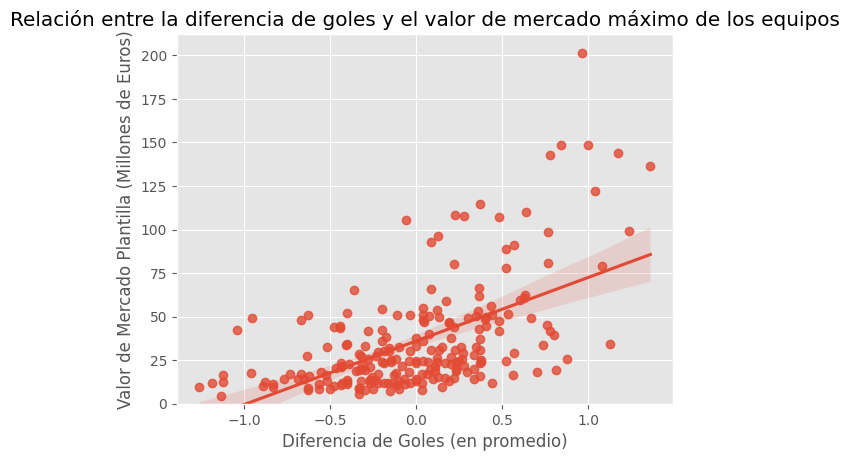

In [24]:
# Visualización mediante gráfico de dispersión con línea de tendencia (Regplot)
sns.regplot(data= joinvalor, x="difgoles", y="valor_mercado");
plt.title("Relación entre la diferencia de goles y el valor de mercado máximo de los equipos")
plt.xlabel("Diferencia de Goles (en promedio)")
plt.ylabel("Valor de Mercado Plantilla (Millones de Euros)")
plt.ylim(bottom = 0)
plt.grid(True)
plt.show()

In [25]:
# El coeficiente R^2 indicará qué porcentaje de la variabilidad del éxito se explica por el valor de mercado
df_reg_valor = joinvalor.dropna(subset=["valor_mercado", "difgoles"])

# Realizar la regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(df_reg_valor["valor_mercado"], df_reg_valor["difgoles"])
print(f"El coeficiente de correlación (R-cuadrado) es: {r_value**2:.2f}")

El coeficiente de correlación (R-cuadrado) es: 0.32


**¿Existe una relación consistente entre el valor de mercado del equipo y el resultado del partido?**

A través del gráfico de dispersión, observamos una tendencia positiva: en líneas generales, los equipos con plantillas más costosas tienden a lograr mejores diferencias de gol. Sin embargo, con un coeficiente de correlación del 32%, podemos concluir que, si bien el dinero es un factor influyente, no es determinante por sí solo. Esto significa que casi el 70% del éxito en la cancha depende de otros factores ajenos al presupuesto (como la táctica, el estado físico o la química del equipo), por lo que un plantel valioso aumenta las probabilidades de ganar, pero no garantiza resultados consistentes de forma automática.

###2️⃣ ¿Ser local sigue siendo una ventaja real entre 2015 y 2022?

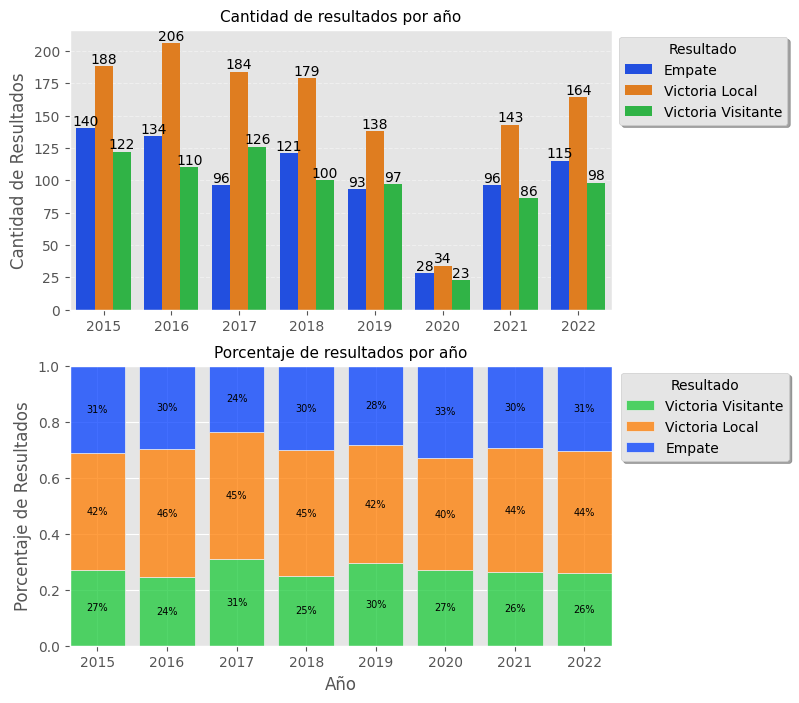

In [26]:
# Agrupación y conteo de resultados por año para identificar tendencias en volumen de victorias y empates
result_counts = df_arg.groupby(["anio", "resultado"]).size().reset_index(name="count")
result_counts = result_counts.replace({0: "Empate", 1: "Victoria Local", 2: "Victoria Visitante"})

# Visualización comparativa de frecuencias anuales mediante gráficos de barras con etiquetas de datos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))

aq= sns.barplot(
    data=result_counts,
    x="anio",
    y="count",
    hue="resultado",
    palette= "bright",
    ax= axes[0]
)
for container in aq.containers:
      aq.bar_label(container)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)
axes[0].set_title("Cantidad de resultados por año", fontsize=11)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Cantidad de Resultados", fontsize= 12)
axes[0].legend(title= "Resultado", bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1)

# Análisis de composición proporcional mediante un histograma apilado al 100%
df_localia = df_arg.copy()
df_localia["resultado"] = df_arg["resultado"].replace({0: "Empate", 1: "Victoria Local", 2: "Victoria Visitante"})

al = sns.histplot(
    data = df_localia.sort_values(by= "resultado", ascending= True),
    x = "anio",
    hue = "resultado",
    multiple = "fill",
    stat = "proportion",
    palette= "bright",
    discrete = True,
    shrink = 0.8,
    ax= axes[1]
)
axes[1].set_title("Porcentaje de resultados por año", fontsize=11)
axes[1].set_xlabel("Año", fontsize= 12)
axes[1].set_ylabel("Porcentaje de Resultados", fontsize= 12)
axes[1].legend(title= "Resultado", labels=["Victoria Visitante", "Victoria Local", "Empate"], loc="upper center", bbox_to_anchor=(1.171, 1),
          fancybox=True, shadow=True, ncol=1)

# Agregar porcentajes
for patch in al.patches:
    height = patch.get_height()
    if height > 0.04:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + height / 2
        al.text(x, y, f"{height:.0%}", ha="center", va="center", color="black", fontsize=7)

plt.show()

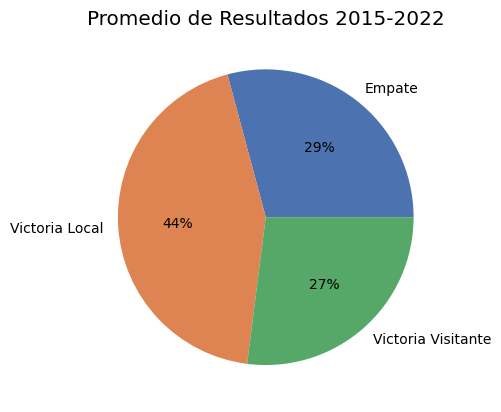

In [27]:
# Resumen histórico general (2015-2022) mediante un gráfico de torta para determinar el promedio de localía
rc2 = (result_counts.groupby("resultado")["count"].sum())
rc2["resultado"] = rc2.index
rc2 = rc2.reset_index(drop=True)
rc2 = rc2.iloc[:-1]

rc2list = []

for a in rc2:
  rc2list.append(a)

lb = result_counts.iloc[:3]
lb = lb.drop(columns=["count", "anio"])

lb2 = ["Empate", "Victoria Local", "Victoria Visitante"]

plt.pie(x = rc2list, labels = lb2, colors = sns.color_palette("deep")[0:3], autopct="%.0f%%")
plt.title("Promedio de Resultados 2015-2022")
plt.show()

/tmp/ipython-input-2969653465.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= df_arg, x= "anio", y="prob_v_local", ci=None)
/tmp/ipython-input-2969653465.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= df_arg, x= "anio", y="prob_v_visitante", ci=None)
/tmp/ipython-input-2969653465.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= df_arg, x= "anio", y="prob_empate", ci=None)


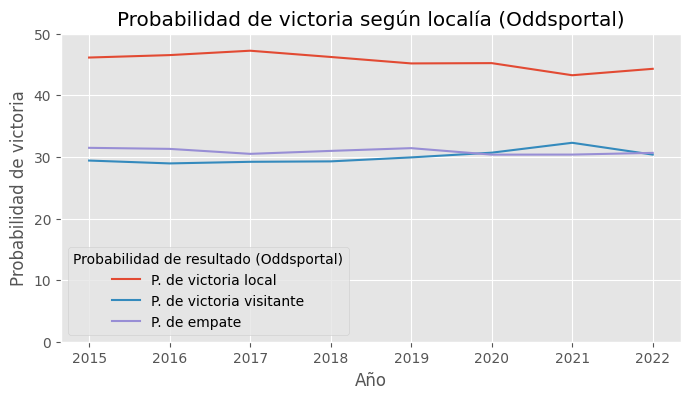

Este gráfico se trata de una aproximación estimada de la probabilidad implícita en las cuotas.


In [28]:
# Contraste con el mercado de apuestas: Cálculo de probabilidades implícitas a partir de las cuotas (Odds)
# La fórmula (100 / cuota) permite transformar el precio de la apuesta en una probabilidad estimada por el mercado

# estimación de probabilidades de resultados
df_arg["prob_v_local"] = df_arg.apuesta_local.apply(lambda x: 100/x)
df_arg["prob_v_visitante"] = df_arg.apuesta_visitante.apply(lambda x: 100/x)
df_arg["prob_empate"] = df_arg.apuesta_empate.apply(lambda x: 100/x)

# Visualización de series temporales de probabilidades de las casas de apuestas (Oddsportal)
plt.figure(figsize=(8, 4))
sns.lineplot(data= df_arg, x= "anio", y="prob_v_local", ci=None)
sns.lineplot(data= df_arg, x= "anio", y="prob_v_visitante", ci=None)
sns.lineplot(data= df_arg, x= "anio", y="prob_empate", ci=None)
plt.title("Probabilidad de victoria según localía (Oddsportal)")
plt.xlabel("Año")
plt.ylabel("Probabilidad de victoria")
plt.ylim(bottom=0, top= 50)
plt.grid(True)
plt.ylim(bottom=0)
plt.legend(title= "Probabilidad de resultado (Oddsportal)", labels=["P. de victoria local", "P. de victoria visitante", "P. de empate"])
plt.show()
print("Este gráfico se trata de una aproximación estimada de la probabilidad implícita en las cuotas.")

**¿Los equipos locales ganan significativamente más que los visitantes?**

A través del análisis de los resultados históricos, se confirma que la localía otorga una ventaja competitiva clara: el equipo local gana con mayor frecuencia que el visitante en todos los años analizados. Esta tendencia alcanza su punto máximo en 2016, año en el que las victorias locales duplicaron casi por completo a las visitantes (206 frente a 110).

En términos generales, entre 2015 y 2022, el 44% de los encuentros terminaron en victoria local, superando ampliamente el 27% de victorias visitantes y el 29% de empates. De hecho, en 6 de los 8 años observados, para un equipo visitante fue más probable empatar que ganar el partido. Esta realidad estadística es validada por el mercado, ya que las casas de apuesta asignan consistentemente una mayor probabilidad de victoria (y por ende, menor cuota) a los equipos que juegan en su propio estadio.

### 3️⃣ ¿Los equipos con planteles más jóvenes rinden mejor o peor?

In [29]:
# Validación de variable principal
df_arg[(df_arg["edad_media_local"] < df_arg["edad_media_local"].min()) | (df_arg["edad_media_local"] > df_arg["edad_media_local"].max())]
# Observo edad mínima y máxima
# print(df_arg["edad_media_local"].min()) # = 22.69811320754717
# print(df_arg["edad_media_local"].max()) # = 28.52380952380953

# No hay valores irregulares

,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate,anio,mes,prob_v_local,prob_v_visitante,prob_empate


In [30]:
# Agrupación por torneo y equipo para capturar la edad media máxima registrada en cada ciclo de fichajes
df_edades = df_arg.groupby(["torneo", "equipo_local"])["edad_media_local"].max()

# Consolidación de métricas de desempeño: total de goles marcados y recibidos por equipo en cada torneo
df_goles_favor = df_arg.groupby(["torneo", "equipo_local"])["goles_local"].sum()
df_goles_contra = df_arg.groupby(["torneo", "equipo_local"])["goles_visitante"].sum()

In [31]:
# Integración de datos de edad y rendimiento en un dataframe único para el análisis de correlación
df_edades = df_puntos.groupby(["torneo", "equipo"])["edad_media"].max()
df_goles_favor = df_puntos.groupby(["torneo", "equipo"])["goles_marcados"].sum()
df_goles_contra = df_puntos.groupby(["torneo", "equipo"])["goles_recibidos"].sum()

joinedades = df_edades.reset_index().join(
    [(df_goles_favor.reset_index()["goles_marcados"]), df_goles_contra.reset_index()["goles_recibidos"]],
    how="inner")
joinedades

,torneo,equipo,edad_media,goles_marcados,goles_recibidos
0,Campeonato 2015,Aldosivi,28.10,37,40
1,Campeonato 2015,Argentinos,24.71,30,38
2,Campeonato 2015,Arsenal,24.86,25,44
3,Campeonato 2015,Atl Rafaela,24.71,29,51
4,Campeonato 2015,Banfield,24.42,38,32
...,...,...,...,...,...
217,Transicion 2016,Sarmiento (J),26.52,10,18
218,Transicion 2016,Temperley,26.88,14,21
219,Transicion 2016,Tigre,26.12,21,17
220,Transicion 2016,Union,24.17,24,22


Text(0, 0.5, 'Cantidad de goles marcados')

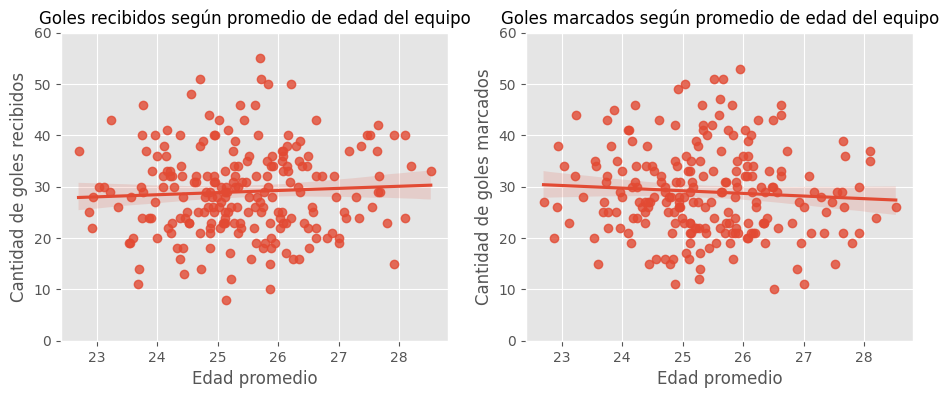

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
# Evaluación de la capacidad defensiva: Relación entre la edad promedio y los goles recibidos
sns.regplot(data= joinedades, x="edad_media", y="goles_recibidos", ax= axes[0]);
axes[0].set_title("Goles recibidos según promedio de edad del equipo", fontsize=12)
axes[0].set_xlabel("Edad promedio")
axes[0].set_ylabel("Cantidad de goles recibidos")
axes[0].set_ylim(bottom= 0, top = 60)

# Evaluación del poder ofensivo: Relación entre la edad promedio y los goles marcados
sns.regplot(data= joinedades, x="edad_media", y="goles_marcados", ax=axes[1]);
axes[1].set_title("Goles marcados según promedio de edad del equipo", fontsize=12)
axes[1].set_ylim(bottom= 0, top = 60)
axes[1].set_xlabel("Edad promedio")
axes[1].set_ylabel("Cantidad de goles marcados")

In [33]:
# Cálculo del coeficiente R-cuadrado para cuantificar la influencia de la edad en los goles recibidos
df_reg_edad = joinedades.dropna(subset=["edad_media", "goles_recibidos"])

# Realizar la regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(df_reg_edad["edad_media"], df_reg_edad["goles_recibidos"])
print(f"El coeficiente de correlación (R-cuadrado) es: {r_value**2:}")


El coeficiente de correlación (R-cuadrado) es: 0.0032835359973276833


In [34]:
# Validación estadística de la relación entre veteranía/juventud y capacidad anotadora
df_reg_edad2 = joinedades.dropna(subset=["edad_media", "goles_marcados"])

# Realizar la regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(df_reg_edad2["edad_media"], df_reg_edad2["goles_marcados"])
print(f"El coeficiente de correlación (R-cuadrado) es: {r_value**2:}")

El coeficiente de correlación (R-cuadrado) es: 0.0046634007995271344


**¿La edad promedio del equipo influye en los resultados?**

Según los gráficos de dispersión, la influencia de la edad promedio de los planteles en el desempeño deportivo es prácticamente inexistente. El análisis estadístico revela que la edad no explica de manera significativa ni los goles recibidos ni los goles marcados, con un impacto casi nulo en ambos indicadores.

La edad del jugador no parece ser un factor determinante de su rendimiento actual en el campo. Por lo tanto, no debería ser considerada una métrica crítica para la toma de decisiones administrativas (como contrataciones o renovaciones).

### 4️⃣ ¿Las casas de apuestas predicen bien los resultados?

In [35]:
# Validación de variable principal
df_arg[(df_arg["apuesta_local"] <= 0) | (df_arg["apuesta_visitante"] <= 0) | (df_arg["apuesta_empate"] <= 0)]

# No hay valores irregulares

,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate,anio,mes,prob_v_local,prob_v_visitante,prob_empate


In [36]:
# Aclaración: Las cuotas de apuestas de este dataset son brindadas por Oddsportal

# Lógica implicita tras la cuota: cuanto más baja la cuota, más probable que se dé
# tal resultado. Cuanto más alta la cuota, más improbable que se dé tal resultado
# Probabilidad implícita: Se puede aproximar qué probabilidad estima la casa
# dividiendo 100 entre la cuota decimal (ej. cuota 2.00 = 50% de probabilidad)

# df_arg["apuesta_local"].describe()
# min: 1,14. Max: 11,25
#df_arg["apuesta_visitante"].describe()
# min: 1,26. Max: 17,97
# df_arg["apuesta_empate"].describe()
# min: 2,06. Max: 7,67

# Cálculo de la probabilidad implícita: Transformación de cuotas decimales a porcentajes de probabilidad
df_arg["prob_v_local"] = df_arg.apuesta_local.apply(lambda x: 100/x)
df_arg["prob_v_visitante"] = df_arg.apuesta_visitante.apply(lambda x: 100/x)
df_arg["prob_empate"] = df_arg.apuesta_empate.apply(lambda x: 100/x)

In [37]:
# Construcción de un modelo de predicción simplificado basado en la probabilidad máxima:

# Se asume como "predicción oficial" aquel resultado que posea el mayor porcentaje de probabilidad implícita
df_prediccion = df_arg[["prob_v_local", "prob_v_visitante", "prob_empate", "resultado"]].copy()

# Extracción del valor máximo de probabilidad por cada fila para identificar el pronóstico principal
prediccionlist = []
for a in df_prediccion.values:
  prediccionlist.append(str(max(a).round(2)))

df_prediccion["prob.prediccion"] = prediccionlist
df_prediccion["prob.prediccion"] = df_prediccion["prob.prediccion"].astype(float)

In [38]:
# Asignación de etiquetas de predicción (Victoria Local, Visitante o Empate) mediante lógica condicional
condiciones = [
    df_prediccion["prob.prediccion"].round(2) == df_prediccion["prob_v_local"].round(2),
    df_prediccion["prob.prediccion"].round(2) == df_prediccion["prob_v_visitante"].round(2)
]

elegir = [
    "victoria local",
    "victoria visitante"
]

df_prediccion["prediccion"] = np.select(condiciones, elegir, default="empate")

display(df_prediccion.head())

,prob_v_local,prob_v_visitante,prob_empate,resultado,prob.prediccion,prediccion
0,57.14,19.96,29.67,1,57.14,victoria local
1,55.56,20.75,30.96,2,55.56,victoria local
2,58.82,18.02,29.94,1,58.82,victoria local
3,48.54,26.18,32.36,2,48.54,victoria local
4,49.26,26.18,31.75,0,49.26,victoria local


In [39]:
# Evaluación de precisión: Contraste directo entre la predicción de la casa y el resultado real del partido:
# Se categoriza como "Acierto" si el pronóstico coincide con el evento ocurrido, de lo contrario se marca como "Error"
df_prediccion["certeza"] = np.where(
    (df_prediccion["prediccion"]  == "victoria local") & (df_prediccion["resultado"] == 1) |
    (df_prediccion["prediccion"]  == "victoria visitante") & (df_prediccion["resultado"] ==2) |
    (df_prediccion["prediccion"]  == "empate") & (df_prediccion["resultado"] ==0), "Acierto", "Error")

df_prediccion["certeza"].value_counts() / len(df_prediccion)

,count
certeza,
Error,0.52
Acierto,0.48


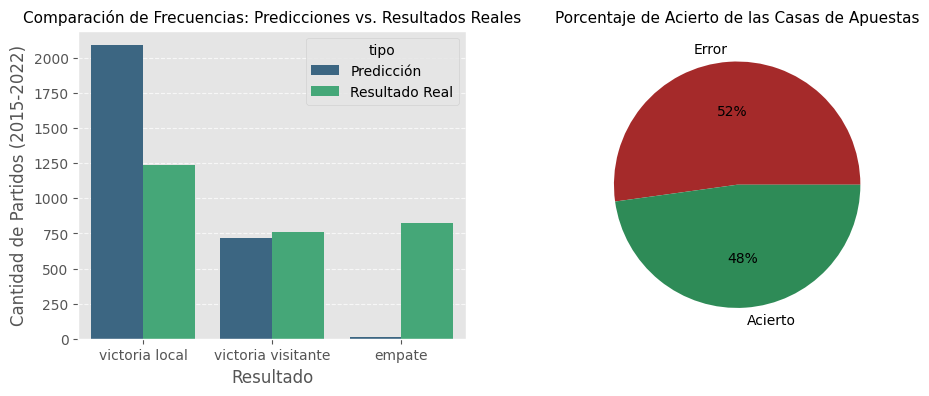

*Se asume como 'predicción oficial' aquel resultado que posea el mayor porcentaje de probabilidad implícita.


In [40]:
# Transformar la columna "resultado" a strings para que coincida con "prediccion"
df_prediccion_plot = df_prediccion.copy()
df_prediccion_plot["resultado_str"] = df_prediccion_plot["resultado"].map({0: "empate", 1: "victoria local", 2: "victoria visitante"})

# Consolidación de conteos para representación gráfica multivariable
pred_cont = df_prediccion_plot["prediccion"].value_counts().reset_index()
pred_cont.columns = ["resultado", "count"]
pred_cont["tipo"] = "Predicción"

real_cont = df_prediccion_plot["resultado_str"].value_counts().reset_index()
real_cont.columns = ["resultado", "count"]
real_cont["tipo"] = "Resultado Real"

# Unir los DataFrames de conteo
cont_total = pd.concat([pred_cont, real_cont])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
# Visualización comparativa de frecuencias: Distribución de lo predicho vs. lo ocurrido en la realidad
sns.barplot(data=cont_total, x="resultado", y="count", hue="tipo", palette="viridis", ax=axes[0])
axes[0].set_title("Comparación de Frecuencias: Predicciones vs. Resultados Reales", fontsize=11)
axes[0].set_xlabel("Resultado")
axes[0].set_ylabel("Cantidad de Partidos (2015-2022)")
#axes[0].set_legend(title="Tipo")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

axes[1].pie(df_prediccion["certeza"].value_counts(), labels=df_prediccion["certeza"].value_counts().index, autopct="%.0f%%", colors=["brown", "seagreen"])
# cambiar palette a dark
axes[1].set_title("Porcentaje de Acierto de las Casas de Apuestas", fontsize=11)
plt.show()
print("*Se asume como 'predicción oficial' aquel resultado que posea el mayor porcentaje de probabilidad implícita.")

In [41]:
# El equilibrio en victoria visitante podría indicar que la predicción suele ser muy acertada cuando sugiere que pierden los locales.
# De esto se infiere un supuesto: Cuando las casas de apuestas predicen que el partido es victoria del visitante, casi siempre aciertan.
# Verificación de este supuesto:
(df_prediccion[df_prediccion["prediccion"]== "victoria visitante"]["certeza"].value_counts()) / (len(df_prediccion[df_prediccion["prediccion"]== "victoria visitante"]))

,count
certeza,
Error,0.57
Acierto,0.43


**¿Las casas de apuestas predicen bien los resultados?**

Según el gráfico de barras, las casas de apuestas tienden a sobreestimar la capacidad de los equipos locales para ganar partidos y muestran una marcada reticencia a sugerir que un encuentro terminará en empate. Esta brecha se hace evidente al comparar el volumen de predicciones de victoria local frente a la cantidad de veces que este resultado ocurre realmente en la cancha.

En términos globales, el nivel de precisión de las casas de apuestas es del 48%, lo que significa que fallan en más de la mitad de sus pronósticos (52%). Aunque a simple vista la predicción de victorias visitantes parece alinearse con la realidad, el análisis detallado indica que su efectividad es limitada, situándose incluso por debajo del promedio general de aciertos.

###5️⃣ ¿Boca y River juegan “distinto” al resto?

In [42]:
# ¿Boca y River juegan “distinto” al resto?
# ¿Distinto en qué métrica?, Esto se analizará mediante:
    # goles marcados/recibidos
    # valor de mercado
    # resultados
    # posesion
    # puntos totales

In [43]:
# Extracción y cálculo de goles marcados y recibidos por River Plate en condición de local y visitante

# Local River
chequeo_river= df_arg[["torneo", "anio", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante"]].copy()
chequeo_river["goles_marcados"]= np.where(
    df_arg["equipo_local"] == "River Plate", df_arg["goles_local"],
    np.where(df_arg["equipo_visitante"]== "River Plate", df_arg["goles_visitante"], 0)
)

# Visitante River
chequeo_river["goles_en_contra"]= np.where(
    df_arg["equipo_local"] == "River Plate", df_arg["goles_visitante"],
    np.where(df_arg["equipo_visitante"]== "River Plate", df_arg["goles_local"], 0)
)

chequeo_river["difgoles"] = chequeo_river["goles_marcados"] - chequeo_river["goles_en_contra"]

# Procesamiento simétrico de datos para Boca Juniors para asegurar la comparabilidad de las métricas
# Local Boca
chequeo_boca= df_arg[["torneo", "anio", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante"]].copy()
chequeo_boca["goles_marcados"]= np.where(
    df_arg["equipo_local"] == "Boca Juniors", df_arg["goles_local"],
    np.where(df_arg["equipo_visitante"]== "Boca Juniors", df_arg["goles_visitante"], 0)
)

# Visitante Boca
chequeo_boca["goles_en_contra"]= np.where(
    df_arg["equipo_local"] == "Boca Juniors", df_arg["goles_visitante"],
    np.where(df_arg["equipo_visitante"]== "Boca Juniors", df_arg["goles_local"], 0)
)

chequeo_boca["difgoles"] = chequeo_boca["goles_marcados"] - chequeo_boca["goles_en_contra"]

chequeo_boca.groupby(["anio"])[["goles_marcados", "goles_en_contra", "difgoles"]].sum().sort_values(["anio"], ascending=False)

# Cálculo del rendimiento base de la liga excluyendo a Boca y River
sinbocariver = df_arg[["torneo", "anio", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante"]].copy()
sinbocariver["goles_marcados"]= sinbocariver["goles_local"] + sinbocariver["goles_visitante"]
sinbocariver["goles_en_contra"]= sinbocariver["goles_local"] + sinbocariver["goles_visitante"]


In [44]:
# Se determina la cantidad de equipos participantes por año para calcular promedios representativos
qequipos = df_arg.groupby(["anio"])["equipo_local"].nunique()
qequipossinbocariver = qequipos - 2

In [45]:
sinbocariver.groupby(["anio"])[["goles_marcados", "goles_en_contra"]].sum().sort_values(["anio"], ascending=False)
# Agregación anual de goles y deducción de los registros de Boca y River del total general
sinbocariver2 = sinbocariver.groupby(["anio"])[["goles_marcados", "goles_en_contra"]].sum()
chequeo_boca2 = chequeo_boca.groupby(["anio"])[["goles_marcados", "goles_en_contra"]].sum()
chequeo_river2 = chequeo_river.groupby(["anio"])[["goles_marcados", "goles_en_contra"]].sum()

# Normalización de los datos: Cálculo de goles promedio por equipo para una comparación justa frente a los grandes
sinbocariver3 = sinbocariver2 - chequeo_boca2 - chequeo_river2
sinbocariver3.sort_values(["anio"], ascending=False)

sinbocariver3["difgoles"] = sinbocariver3["goles_marcados"] - sinbocariver3["goles_en_contra"]
sinbocariver3["goles_marcados.mean"] = sinbocariver3["goles_marcados"] /qequipossinbocariver
sinbocariver3["goles_en_contra.mean"] = sinbocariver3["goles_en_contra"] /qequipossinbocariver

chequeo_river2 = chequeo_river.groupby(["anio"])[["goles_marcados", "goles_en_contra", "difgoles"]].sum().sort_values(["anio"], ascending=False)
chequeo_boca2 = chequeo_boca.groupby(["anio"])[["goles_marcados", "goles_en_contra", "difgoles"]].sum().sort_values(["anio"], ascending=False)


/tmp/ipython-input-674089845.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= sinbocariver3, x= "anio", y= "goles_marcados.mean", palette = "pastel", color="green", ci=None, ax= axes[0])
/tmp/ipython-input-674089845.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data= sinbocariver3, x= "anio", y= "goles_marcados.mean", palette = "pastel", color="green", ci=None, ax= axes[0])
/tmp/ipython-input-674089845.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= chequeo_boca2, x= "anio", y= "goles_marcados", palette = "pastel", color="blue", ci= None, ax = axes[0])
/tmp/ipython-input-674089845.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data= chequeo_boca2, x= "anio", y= "goles_marcados", palette = "pastel", color="blue", ci= None, ax = axes[0])
/tmp/ipy

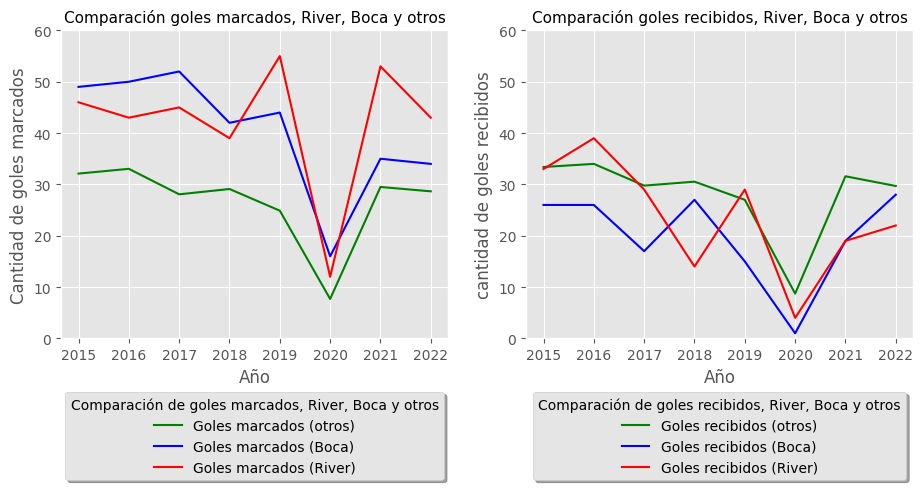

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
# Visualización de series temporales: Comparación de la efectividad ofensiva de Boca y River vs. el promedio del resto
sns.lineplot(data= sinbocariver3, x= "anio", y= "goles_marcados.mean", palette = "pastel", color="green", ci=None, ax= axes[0])
sns.lineplot(data= chequeo_boca2, x= "anio", y= "goles_marcados", palette = "pastel", color="blue", ci= None, ax = axes[0])
sns.lineplot(data= chequeo_river2, x= "anio", y= "goles_marcados", palette = "pastel", color="red", ci= None, ax = axes[0])
axes[0].set_title("Comparación goles marcados, River, Boca y otros", fontsize=11)
axes[0].set_xlabel("Año")
axes[0].set_ylabel("Cantidad de goles marcados")
axes[0].grid(True)
axes[0].set_ylim(bottom=0, top=60)
axes[0].legend(title= "Comparación de goles marcados, River, Boca y otros", labels=["Goles marcados (otros)", "Goles marcados (Boca)", "Goles marcados (River)", "Goles recibidos (River)"], loc="upper center", bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=1)

# Visualización de series temporales: Comparación de la efectividad de la última línea y el arco frente al promedio de los demás competidores
sns.lineplot(data= sinbocariver3, x= "anio", y= "goles_en_contra.mean", color ="green", ci=None, ax= axes[1])
sns.lineplot(data= chequeo_boca2, x= "anio", y= "goles_en_contra", color= "blue", ci= None, ax= axes[1])
sns.lineplot(data= chequeo_river2, x= "anio", y= "goles_en_contra", color="r", ci= None, ax= axes[1])
axes[1].set_title("Comparación goles recibidos, River, Boca y otros", fontsize=11)
axes[1].set_xlabel("Año")
axes[1].set_ylabel("cantidad de goles recibidos")
axes[1].grid(True)
axes[1].set_ylim(bottom=0, top=60)
axes[1].legend(title= "Comparación de goles recibidos, River, Boca y otros", labels=["Goles recibidos (otros)", "Goles recibidos (Boca)", "Goles recibidos (River)"], loc="upper center", bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=1)


In [47]:
# Estudio del poderío económico: Comparación del valor máximo de mercado por plantilla
valorriver= df_arg[df_arg["equipo_local"] == "River Plate"]
valorriver.groupby(["anio"])["valor_mercado_local"].max().sort_index(ascending=False)

valorboca= df_arg[df_arg["equipo_local"] == "Boca Juniors"]
valorboca.groupby(["anio"])["valor_mercado_local"].max().sort_index(ascending=False)

df_valorsinbocariver= df_arg[df_arg["equipo_local"] != "Boca Juniors"]
df_valorsinbocariver= df_valorsinbocariver[df_valorsinbocariver["equipo_local"] != "River Plate"]
df_valorsinbocariver.groupby(["anio"])["valor_mercado_local"].mean().sort_values(ascending=False)

,valor_mercado_local
anio,
2020,42.61
2019,40.29
2018,35.81
2021,31.72
2017,28.97
2022,28.03
2016,24.58
2015,18.57


/tmp/ipython-input-3448084256.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= df_valorsinbocariver, x= "anio", y= "valor_mercado_local", ci= None, color ="green")
/tmp/ipython-input-3448084256.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= valorboca, x= "anio", y= "valor_mercado_local", color= "blue", ci= None, estimator=max)
/tmp/ipython-input-3448084256.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= valorriver, x= "anio", y= "valor_mercado_local", color="r", ci= None, estimator= max)


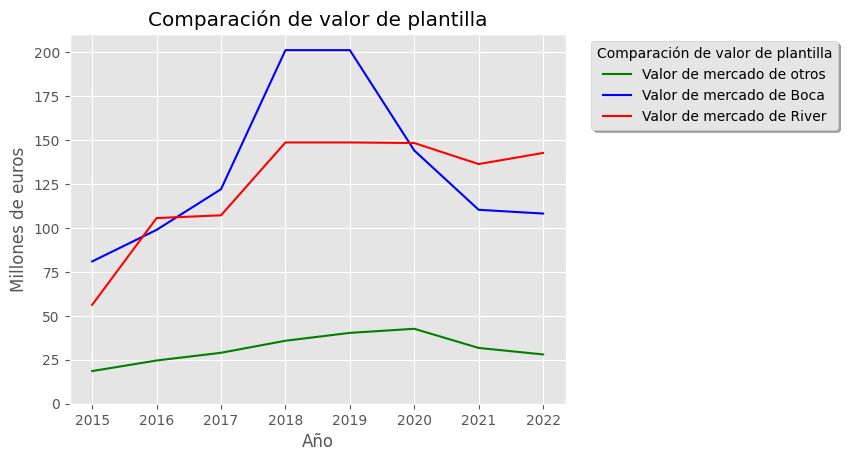

In [48]:
# Visualización de la brecha financiera: Tendencias del valor de mercado en millones de euros (2015-2022)
sns.lineplot(data= df_valorsinbocariver, x= "anio", y= "valor_mercado_local", ci= None, color ="green")
sns.lineplot(data= valorboca, x= "anio", y= "valor_mercado_local", color= "blue", ci= None, estimator=max)
sns.lineplot(data= valorriver, x= "anio", y= "valor_mercado_local", color="r", ci= None, estimator= max)

sns.lineplot
plt.title("Comparación de valor de plantilla")
plt.xlabel("Año")
plt.ylabel("Millones de euros")
plt.grid(True)
plt.ylim(bottom=0)
plt.legend(title= "Comparación de valor de plantilla", labels=["Valor de mercado de otros", "Valor de mercado de Boca", "Valor de mercado de River"], loc="upper center", bbox_to_anchor=(1.3, 1),
          fancybox=True, shadow=True, ncol=1)
plt.show()

/tmp/ipython-input-511377688.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ak = sns.barplot(data= puntosequipos, x="equipo", y= "puntos", ci=None, estimator=sum, palette="crest")
/tmp/ipython-input-511377688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ak = sns.barplot(data= puntosequipos, x="equipo", y= "puntos", ci=None, estimator=sum, palette="crest")


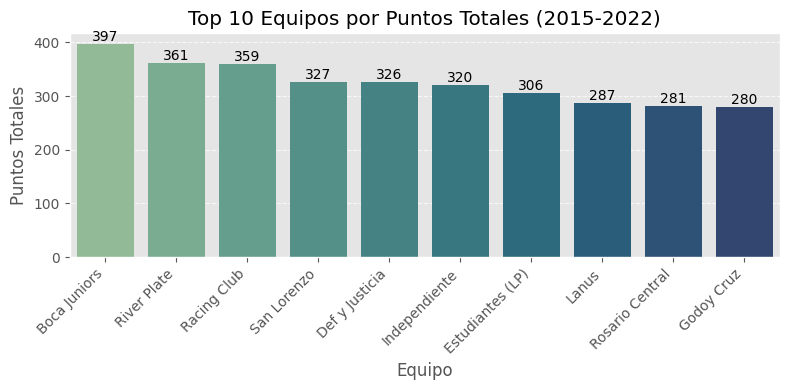

In [49]:
# Ranking histórico acumulado: Los 10 equipos con mayor puntuación total en el periodo analizado
puntosequipos = df_puntos.groupby("equipo").sum().sort_values(["puntos"], ascending=False).head(10)

plt.figure(figsize=(8, 4))
ak = sns.barplot(data= puntosequipos, x="equipo", y= "puntos", ci=None, estimator=sum, palette="crest")
for container in ak.containers:
      ak.bar_label(container)
plt.title("Top 10 Equipos por Puntos Totales (2015-2022)")
plt.xlabel("Equipo")
plt.ylabel("Puntos Totales")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
# Análisis de estilo de juego: Dominio de la posesión del balón (2018-2022)

# df_moderno.nunique() = 34 equipos entre 2018 y 2022

# Se unifican los datos de local y visitante para obtener el promedio de posesión real por equipo
poslocal = df_moderno[["equipo_local", "posesion_local"]]
poslocal = poslocal.rename(columns={"equipo_local": "equipo"})
poslocal = poslocal.rename(columns={"posesion_local": "posesion"})
posvis = df_moderno[["equipo_visitante", "posesion_visitante"]]
posvis = posvis.rename(columns={"equipo_visitante": "equipo"})
posvis = posvis.rename(columns={"posesion_visitante": "posesion"})

postotal = pd.concat([poslocal, posvis])

postotal = postotal.groupby("equipo").mean().sort_values(by= "posesion", ascending = False).head(10)

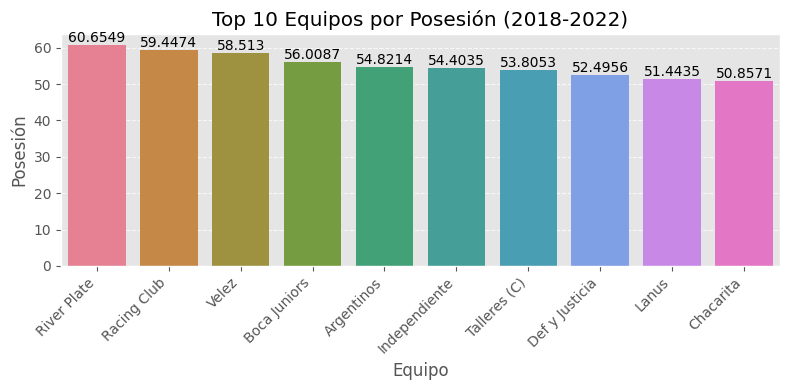

In [51]:
# Identificación de los 10 equipos con mayor vocación de control de juego según el promedio de posesión
plt.figure(figsize= (8,4))
ap = sns.barplot(data = postotal, x= "equipo", y = "posesion", hue= "equipo")
for container in ap.containers:
      ap.bar_label(container)
plt.title("Top 10 Equipos por Posesión (2018-2022)")
plt.xlabel("Equipo")
plt.ylabel("Posesión")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

**¿Los partidos de Boca y River presentan /estadísticas diferentes/ al promedio de la liga?**

El análisis integral de los datos confirma que Boca Juniors y River Plate operan en una dimensión estadística superior al resto de la liga en múltiples categorías clave:
* Poderío Ofensivo y Defensivo: Ambos equipos mantienen consistentemente una mayor cantidad de goles marcados y una menor cantidad de goles recibidos en comparación con el promedio de los demás clubes de la liga.

* Brecha Económica: La diferencia en el valor de mercado de sus plantillas respecto al resto es drástica. Esta disparidad fue especialmente crítica entre 2018 y 2020, cuando ambos clubes superaron los 140 millones de euros, mientras que el promedio del resto de los equipos no alcanzó los 50 millones.

* Dominio en Resultados y Estilo: Boca y River encabezan la tabla de puntos totales acumulados en el período 2015-2022, con Boca en el primer lugar (397 pts) y River en el segundo (361 pts). Además, en términos de estilo de juego, de los 34 equipos analizados entre 2018 y 2022, River Plate lidera la liga con la mayor posesión promedio (61%), mientras que Boca Juniors se posiciona en el cuarto lugar con un 56%.

Como conclusión, la combinación de una inversión económica significativamente mayor se traduce de manera directa en un dominio deportivo claro, tanto en el control de los partidos como en la obtención de puntos y goles.

### 6️⃣ ¿La posesión del balón define al ganador en el fútbol argentino?

In [52]:
# Segmentación de la posesión según el resultado: Análisis de equipos que ganan vs. equipos que pierden

#Extracción de promedios de posesión para victorias y derrotas, tanto en condición de local como de visitante
df_posesionviclocal = df_moderno[df_moderno["resultado"] == 1][["posesion_local"]]
df_posesionviclocal = df_posesionviclocal.rename(columns={"posesion_local": "posesionviclocal"})
# cuando sos local y ganas el partido, tenés un 49% de posesión en promedio

df_posesionderlocal = df_moderno[df_moderno["resultado"] == 2][["posesion_local"]]
df_posesionderlocal = df_posesionderlocal.rename(columns={"posesion_local": "posesionderlocal"})
# cuando sos local y perdes el partido, tenés un 53% de posesión en promedio

df_posesiondervisitante = df_moderno[df_moderno["resultado"] == 1][["posesion_visitante"]]
df_posesiondervisitante = df_posesiondervisitante.rename(columns={"posesion_visitante": "posesiondervis"})
# cuando sos visitante y perdes el partido, tenés un 51% de posesión en promedio

df_posesionvicvisitante = df_moderno[df_moderno["resultado"] == 2][["posesion_visitante"]]
df_posesionvicvisitante = df_posesionvicvisitante.rename(columns={"posesion_visitante": "posesionvicvis"})
# cuando sos visitante y ganas el partido, tenés un 47% de posesión en promedio

# para verlo todo en conjunto:
df_postotal = df_posesionviclocal.join([df_posesionderlocal, df_posesiondervisitante, df_posesionvicvisitante], how= "outer")
df_postotal.describe()

,posesionviclocal,posesionderlocal,posesiondervis,posesionvicvis
count,652.00,397.00,652.00,397.00
mean,49.32,53.33,50.68,46.67
std,10.56,10.62,10.56,10.62
min,22.00,21.00,19.00,18.00
25%,42.00,46.00,43.00,39.00
50%,48.00,54.00,52.00,46.00
75%,57.00,61.00,58.00,54.00
max,81.00,82.00,78.00,79.00


In [53]:
# Cálculo de la diferencia de goles relativa a cada equipo (Local y Visitante) para normalizar la muestra
df_scatter = df_moderno
df_scatter["difgoles"] = df_scatter["goles_local"] - df_scatter["goles_visitante"]
df_scatter["posesion"] = df_scatter["posesion_local"]

df_scatter = df_scatter[["posesion", "difgoles"]]

df_scatter2 = df_moderno
df_scatter2["difgoles"] = df_scatter2["goles_visitante"] - df_scatter2["goles_local"]
df_scatter2["posesion"] = df_scatter2["posesion_visitante"]

df_scatter2 = df_scatter2[["posesion", "difgoles"]]

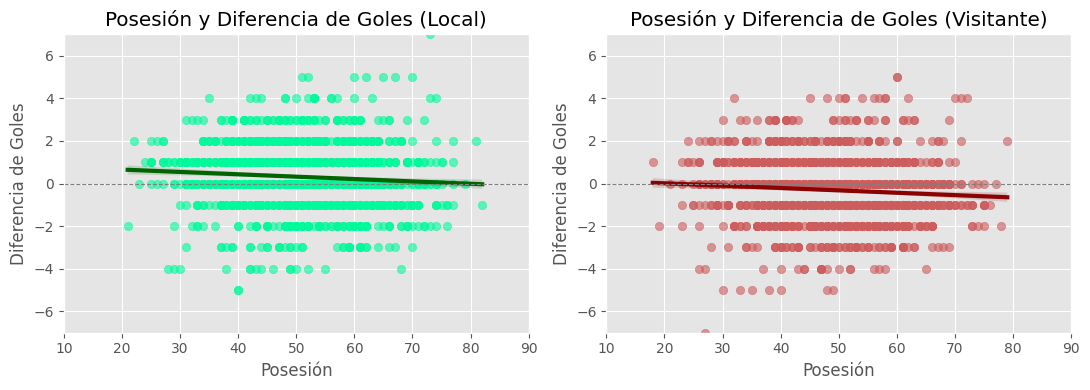

In [54]:
# Visualización mediante Scatter Plot diferenciado por color (Local: verde, Visitante: rojo)
df_scattertotal = pd.concat([df_scatter, df_scatter2])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
# Eliminar plt.figure(figsize=(8, 4)) ya que se crea con plt.subplots

# Primer subplot para el equipo local
axes[0].scatter(x=df_scatter["posesion"][~df_scatter["posesion"].isnull()], y=df_scatter["difgoles"][~df_scatter["posesion"].isnull()], alpha=0.6, color="mediumspringgreen", label="Datos Local")
sns.regplot(data=df_scatter, x="posesion", y="difgoles", scatter=False, color="darkgreen", line_kws={"linewidth":3}, ax=axes[0])
axes[0].axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
axes[0].set_title("Posesión y Diferencia de Goles (Local)")
axes[0].set_xlabel("Posesión")
axes[0].set_ylabel("Diferencia de Goles")
axes[0].set_ylim(bottom=-7, top= 7)
axes[0].grid(True)
axes[0].set_xlim(left=10, right= 90)

# Segundo subplot para el equipo visitante
axes[1].scatter(x=df_scatter2["posesion"][~df_scatter2["posesion"].isnull()], y=df_scatter2["difgoles"][~df_scatter2["posesion"].isnull()], alpha=0.6, color="indianred", label="Datos Visitante")
sns.regplot(data=df_scatter2, x="posesion", y="difgoles", scatter=False, color="darkred", line_kws={"linewidth":3}, ax=axes[1])
axes[1].axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
axes[1].set_title("Posesión y Diferencia de Goles (Visitante)")
axes[1].set_xlabel("Posesión")
axes[1].set_ylabel("Diferencia de Goles")
axes[1].set_ylim(bottom=-7, top= 7)
axes[1].grid(True)
axes[1].set_xlim(left=10, right= 90)

plt.tight_layout()
plt.show()

**¿La posesión del balón define al ganador en el fútbol argentino? ¿Tener mayor posesión aumenta la probabilidad de ganar un partido?**

Contrario a la creencia popular, el análisis de los datos revela que tener una mayor posesión del balón no aumenta las probabilidades de ganar un partido en el fútbol argentino. De hecho, los gráficos de dispersión muestran una tendencia levemente contraintuitiva: en muchos casos, los equipos logran mejores diferencias de gol cuando tienen menos tiempo la pelota.

Aunque esta relación es muy sutil y no constituye un factor decisivo por sí sola, sugiere que la efectividad y el contraataque pueden ser más determinantes que el control del balón.

En resumen, para la gestión administrativa, la posesión debe verse como un rasgo de estilo de juego y no como una métrica de rendimiento que garantice resultados positivos.

###7️⃣¿Más tiros al arco garantizan ganar un partido?

In [55]:
# Validación de variable principal
df_moderno[(df_moderno["tiros_arco_local"] < 0) | (df_moderno["tiros_arco_visitante"] < 0)]

# No hay valores irregulares

,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local,tiros_arco_local,intentos_local,faltas_local,tiro_esquina_local,posesion_visitante,tiros_arco_visitante,intentos_visitante,faltas_visitante,tiro_esquina_visitante,amarillas_local,amarillas_visitante,rojas_local,rojas_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate,anio,mes,difgoles,posesion


In [56]:
# Evaluación de la eficacia ofensiva: Comparación de tiros realizados según el resultado y la localía
df_tirosviclocal = df_moderno[df_moderno["resultado"] == 1][["tiros_arco_local"]]
df_tirosviclocal = df_tirosviclocal.rename(columns={"tiros_arco_local": "tirosviclocal"})
# df_tirosviclocal.mean() # =  cuando sos local y ganas el partido, tenés 5 tiros al arco en promedio

df_tirosderlocal = df_moderno[df_moderno["resultado"] == 2][["tiros_arco_local"]]
df_tirosderlocal = df_tirosderlocal.rename(columns={"tiros_arco_local": "tirosderlocal"})
# df_tirosderlocal.mean() # = cuando sos local y perdes el partido, tenés 3,7 tiros al arco en promedio

df_tirosdervisitante = df_moderno[df_moderno["resultado"] == 1][["tiros_arco_visitante"]]
df_tirosdervisitante = df_tirosdervisitante.rename(columns={"tiros_arco_visitante": "tirosdervis"})
# df_tirosdervisitante.mean() # = cuando sos visitante y perdes el partido, tenés 3 tiros al arco en promedio

df_tirosvicvisitante = df_moderno[df_moderno["resultado"] == 2][["tiros_arco_visitante"]]
df_tirosvicvisitante = df_tirosvicvisitante.rename(columns={"tiros_arco_visitante": "tirosvicvis"})
# df_tirosvicvisitante.mean() # = cuando sos visitante y ganas el partido, tenés 4.5 tiros al arco en promedio

# El objetivo es validar el promedio de disparos necesarios para asegurar una victoria local vs. visitante
df_tiros_total = df_tirosviclocal.join([df_tirosderlocal, df_tirosdervisitante, df_tirosvicvisitante], how= "outer")
df_tiros_total.describe()

,tirosviclocal,tirosderlocal,tirosdervis,tirosvicvis
count,652.00,397.00,652.00,397.00
mean,5.15,3.69,2.96,4.55
std,2.11,2.27,1.81,2.07
min,0.00,0.00,0.00,1.00
25%,4.00,2.00,2.00,3.00
50%,5.00,3.00,3.00,4.00
75%,6.00,5.00,4.00,6.00
max,13.00,13.00,10.00,14.00


In [57]:
# Construcción de la visualización de correlación entre volumen de disparos y margen de victoria

# Normalización de la diferencia de goles y tiros al arco para el perfil local
df_scatter3 = df_moderno
df_scatter3["difgoles"] = df_scatter3["goles_local"] - df_scatter3["goles_visitante"]
df_scatter3["tiros_arco"] = df_scatter3["tiros_arco_local"]
df_scatter3 = df_scatter3[["tiros_arco", "difgoles"]]

# Normalización simétrica para el perfil visitante
df_scatter4 = df_moderno
df_scatter4["difgoles"] = df_scatter4["goles_visitante"] - df_scatter4["goles_local"]
df_scatter4["tiros_arco"] = df_scatter4["tiros_arco_visitante"]
df_scatter4 = df_scatter4[["tiros_arco", "difgoles"]]

df_scattertotal2 = pd.concat([df_scatter3, df_scatter4])

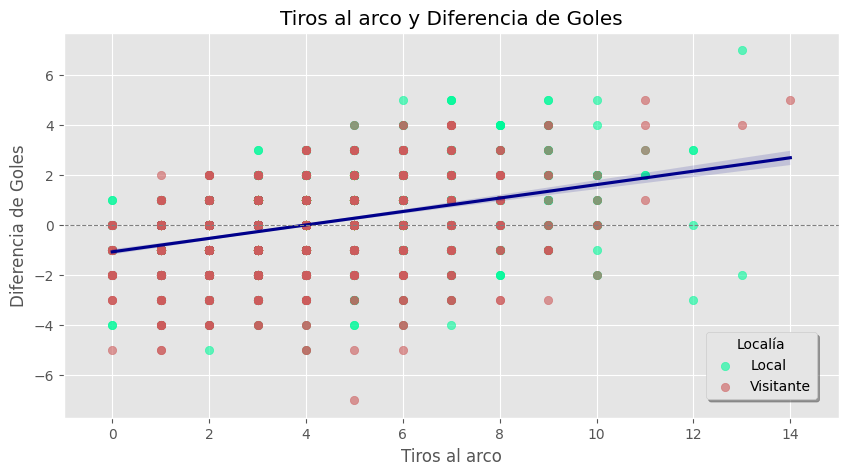

In [58]:
plt.figure(figsize=(10, 5))
plt.scatter(x=df_scatter3["tiros_arco"], y=df_scatter3["difgoles"], alpha=0.6, color="mediumspringgreen")
plt.scatter(x=df_scatter4["tiros_arco"], y=df_scatter4["difgoles"], alpha=0.6, color="indianred")
sns.regplot(data=df_scattertotal2, x="tiros_arco", y="difgoles", scatter=False, color="darkblue")

plt.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Tiros al arco y Diferencia de Goles")
plt.xlabel("Tiros al arco")
plt.ylabel("Diferencia de Goles")
plt.grid(True)
plt.xlim(left=-1, right= 15)
plt.legend(title= "Localía", labels=["Local", "Visitante"], loc="upper center", bbox_to_anchor=(0.90, 0.24),
          fancybox=True, shadow=True, ncol=1)

**¿Más tiros al arco garantizan ganar un partido? ¿El número de tiros al arco es un buen predictor del resultado final?**

El análisis estadístico confirma que existe una relación directa y positiva entre el volumen de disparos y el éxito en el marcador: a mayor cantidad de tiros al arco, aumentan significativamente las probabilidades de lograr una diferencia de goles a favor. Los datos muestran que, en promedio, realizar 5 tiros al arco actuando como local fue suficiente para asegurar una victoria.

A diferencia de la posesión del balón, el número de remates efectivos resulta ser un predictor mucho más confiable del resultado final, ya que refleja una mayor capacidad de generación de peligro real frente al arco rival.


###8️⃣ ¿Qué variable explica mejor el resultado de un partido?

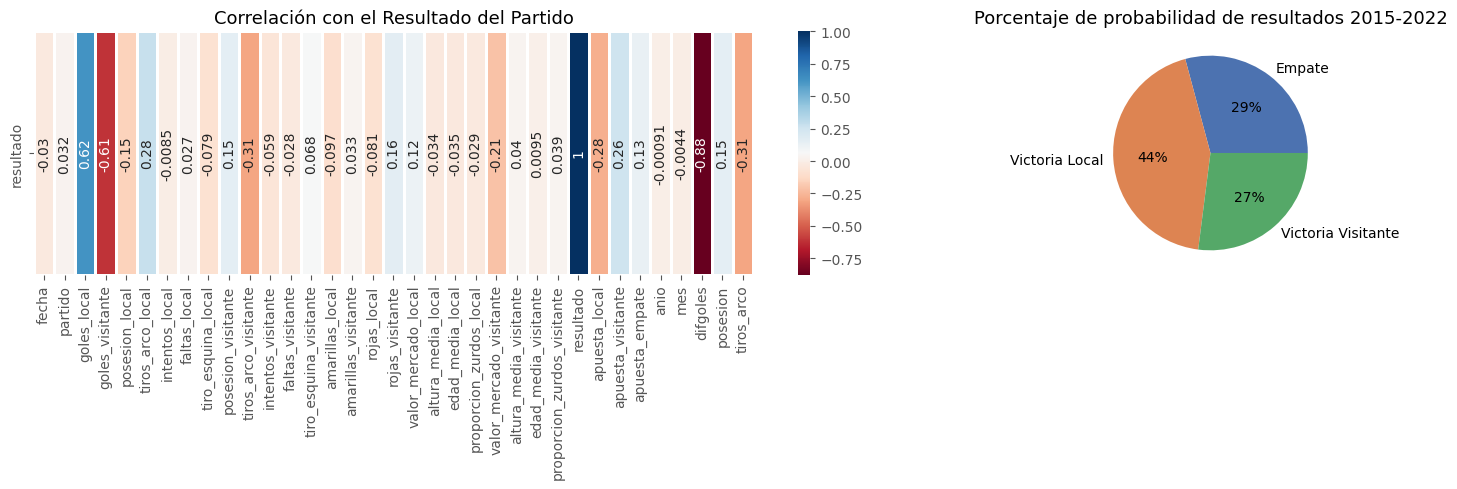

In [59]:
# Análisis Multivariable: Identificación del factor determinante del éxito deportivo

# Se asignan valores de 1 (Victoria Local), -1 (Victoria Visitante) y 0 (Empate) para cuantificar la dirección del éxito
resultera = df_moderno.copy()
resultera["resultado"] = resultera["resultado"].replace({1: 1,
                                                   2: -1,
                                                   0: 0})

resultera = resultera.select_dtypes(include=np.number)
resultera.corr()

correlation_matrix = resultera.corr()
correl_resultado = correlation_matrix[["resultado"]].transpose()


# Visualización del Mapa de Calor
# Los valores cercanos a 1 o -1 indican una relación sólida, mientras que los cercanos a 0 indican irrelevancia
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0]) # Primer subplot para el heatmap
sns.heatmap(correl_resultado, cmap="RdBu", linewidth=1, annot=True, annot_kws={"fontsize":10, "rotation":90}, ax=ax0)
ax0.set_title("Correlación con el Resultado del Partido", fontsize= 13)

ax1 = fig.add_subplot(gs[0, 1]) # Segundo subplot para el pie chart
ax1.pie(x=rc2list, labels=lb2, colors=sns.color_palette("deep")[0:3], autopct="%.0f%%")
ax1.set_title("Porcentaje de probabilidad de resultados 2015-2022", fontsize= 13)

plt.tight_layout()
plt.show()

**¿Qué variable explica mejor el resultado de un partido?**

A través del análisis de correlación (heatmap), se puede concluir que, una vez excluidos factores obvios como los goles marcados o recibidos y las cuotas de las casas de apuestas, la variable que mejor explica el resultado final es el número de tiros al arco, con una correlación positiva de 0.31. Esto indica que la generación de peligro real es el predictor técnico más sólido del éxito en el campo.

En un segundo plano, se encuentran los valores de mercado de las plantillas (0.13 para el equipo local y 0.19 para el visitante) y las variables disciplinarias (hasta 0.16 para las tarjetas rojas del visitante), seguidos por factores de control de juego como la posesión (-0.15).

Complementariamente, el factor campo sigue siendo un pilar fundamental de la liga: ser local otorga históricamente un 44% de probabilidad de alcanzar la victoria, frente a solo un 27% del visitante. En definitiva, las oportunidades de éxito se maximizan cuando un equipo logra transformar su dominio territorial y valor de plantilla en remates efectivos a portería, especialmente bajo la ventaja de jugar en estadio propio.



---



##Otros análisis

### 🚩 Mejores campañas

In [60]:
# Los equipos con más puntos
# Agregación inicial de puntos por torneo y equipo para identificar el volumen total de unidades
maspuntos = df_puntos.groupby(["torneo", "equipo"])["puntos"].sum().sort_values(ascending=False)
# Sin embargo, no todos los torneos tienen la misma cantidad de partidos jugados, por lo que no sería
# correcto decir que el que tiene más puntos tiene mejor campaña. Hay que ponderar por partidos jugados

# Convertir maspuntos a un DataFrame y resetear su índice
maspuntos_df = maspuntos.reset_index()

# Cálculo del denominador: Cantidad de partidos disputados por equipo en cada certamen
partidos_jugados = df_puntos.groupby(["torneo", "equipo"]).size().reset_index(name="partidos_jugados")

# Integración de métricas (Merge) para calcular la eficiencia relativa de cada campaña
maspuntos_partidos = pd.merge(maspuntos_df, partidos_jugados, on=["torneo", "equipo"], how="left")

# Definición de la métrica de "Puntuación Perfecta" (partidos * 3) y cálculo del porcentaje de efectividad
maspuntos_partidos["puntiacion_perfecta"] = maspuntos_partidos["partidos_jugados"] *3
maspuntos_partidos["porcentaje_del_total"] = maspuntos_partidos["puntos"] / maspuntos_partidos["puntiacion_perfecta"]

maspuntos_partidos

,torneo,equipo,puntos,partidos_jugados,puntiacion_perfecta,porcentaje_del_total
0,Campeonato 2015,Boca Juniors,64,30,90,0.71
1,Campeonato 2016/17,Boca Juniors,63,30,90,0.70
2,Campeonato 2015,San Lorenzo,61,30,90,0.68
3,Campeonato 2015,Rosario Central,59,30,90,0.66
4,Campeonato 2017/18,Boca Juniors,58,27,81,0.72
...,...,...,...,...,...,...
217,Transicion 2016,Banfield,15,16,48,0.31
218,Campeonato 2015,Crucero (M),14,30,90,0.16
219,Transicion 2016,Olimpo,13,16,48,0.27
220,Transicion 2016,Argentinos,12,16,48,0.25


In [61]:
# Generación de ranking interno por torneo para identificar la posición final ocupada
maspuntos_partidos["rank"] = maspuntos_partidos.groupby("torneo")["puntos"].rank(ascending=False)

# Muestra las primeras filas con la nueva columna de rank
display(maspuntos_partidos.head())

,torneo,equipo,puntos,partidos_jugados,puntiacion_perfecta,porcentaje_del_total,rank
0,Campeonato 2015,Boca Juniors,64,30,90,0.71,1.00
1,Campeonato 2016/17,Boca Juniors,63,30,90,0.70,1.00
2,Campeonato 2015,San Lorenzo,61,30,90,0.68,2.00
3,Campeonato 2015,Rosario Central,59,30,90,0.66,3.00
4,Campeonato 2017/18,Boca Juniors,58,27,81,0.72,1.00


In [62]:
# Identificación de las 10 campañas más efectivas en la historia reciente (2015-2022)
mejorcampania = maspuntos_partidos.sort_values(by= "porcentaje_del_total", ascending=False).head(10)
# mejorcampania

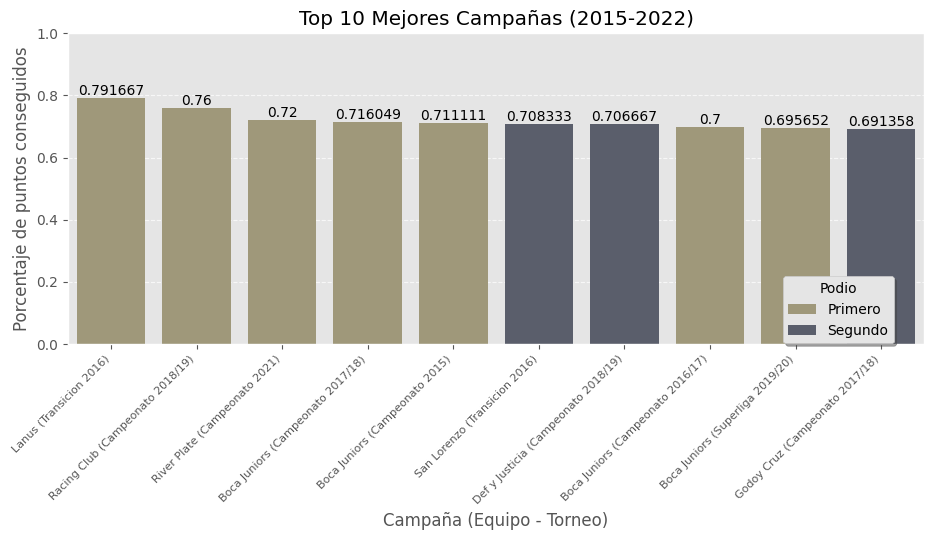

In [63]:
# Visualización mediante gráfico de barras ordenado por efectividad

mejorcampania_plot = mejorcampania.copy()
mejorcampania_plot["campania"] = mejorcampania_plot["equipo"] + " (" + mejorcampania_plot["torneo"].astype(str) + ")"
mejorcampania_plot["rank"] = mejorcampania_plot["rank"].replace({1.0: "Primero",
                                                   2: "Segundo"})

plt.figure(figsize= (9.5,5.5))
am = sns.barplot(data = mejorcampania_plot, x= "campania", y = "porcentaje_del_total", palette="cividis_r", hue= "rank")
for container in am.containers:
      am.bar_label(container)
plt.title("Top 10 Mejores Campañas (2015-2022)")
plt.xlabel("Campaña (Equipo - Torneo)")
plt.ylabel("Porcentaje de puntos conseguidos")
plt.ylim(top = 1)
plt.xticks(rotation=45, ha="right", fontsize= 8) # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.legend(title= "Podio", loc="upper center", bbox_to_anchor=(0.90, 0.24),
          fancybox=True, shadow=True, ncol=1)
plt.show()

**Top 10 Mejores Campañas**

Se destaca la campaña de Lanús en el Transición 2016, alcanzando una efectividad cercana al 79% de los puntos posibles, la más alta del período analizado. Es notable observar que el "'Top 10" no es exclusividad de los clubes con mayor presupuesto; equipos como Defensa y Justicia, Godoy Cruz y Lanús han logrado campañas de eficiencia superior a las de los clubes "grandes", demostrando que una gestión deportiva optimizada puede competir al más alto nivel de rendimiento relativo.

###🏆 Podio de cada Torneo

In [64]:
# Visualización del podio de cada campeonato
# Implementación de visualización interactiva mediante widgets para la exploración de resultados por torneo

# Generación de la lista única de campeonatos disponibles en el dataset para el componente de selección
ver_torneo = df_puntos["torneo"].unique()

# Configuración del widget Dropdown para facilitar la navegación entre diferentes temporadas
selector_torneo = widgets.Dropdown(
    options= ver_torneo,
    description="Elige un torneo:",
    disabled=False,
)

# Mostrar el selector
display(selector_torneo)

Dropdown(description='Elige un torneo:', options=('Campeonato 2015', 'Transicion 2016', 'Campeonato 2016/17', …

/tmp/ipython-input-3915846366.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data= df_podio, x="equipo", y= "puntos", hue="equipo", ci=None, estimator=sum)


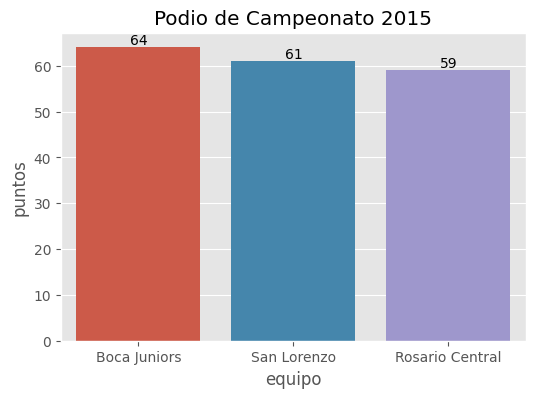

In [65]:
# Filtrado dinámico del conjunto de datos basado en la selección actual del usuario
df_filtorneo = df_puntos[df_puntos["torneo"] == selector_torneo.value]

# Cálculo del podio histórico: Agrupación por puntos y desempate por diferencia de goles
df_podio = df_filtorneo.groupby(["equipo"]).sum().sort_values(by = ["puntos", "difgoles"], ascending=[False, False]).head(3)

# Lógica condicional para el manejo de excepciones: Torneo Transición 2016
# En este certamen, el podio oficial se definió por un partido de tercer puesto y no solo por puntos acumulados
t2016 = df_filtorneo.groupby(["equipo"]).sum().sort_values(by = ["puntos", "difgoles"], ascending=[False, False]).head(4)
t2016b = t2016.loc[t2016.index != "Godoy Cruz"]

# Renderización dinámica del gráfico de barras según el formato del torneo seleccionado
if selector_torneo.value != "Transicion 2016":
  plt.figure(figsize= (6,4))
  ax = sns.barplot(data= df_podio, x="equipo", y= "puntos", hue="equipo", ci=None, estimator=sum)
  for container in ax.containers:
      ax.bar_label(container)
  plt.title("Podio de " + selector_torneo.value)
  plt.show()
else:
  plt.figure(figsize= (6,4))
  ax = sns.barplot(data= t2016b, x="equipo", y= "puntos", hue="equipo", ci=None, estimator=sum)
  for container in ax.containers:
      ax.bar_label(container)
  plt.title("Podio de " + selector_torneo.value)
  plt.show()
  print("Transición 2016*: si bien Godoy Cruz fue el 3er equipo con más puntos del torneo, los segundos de cada zona jugaron partido por tercer puesto, que estableció a Estudiantes de la Plata en el podio*")

### ⚽ Top 10 mayores goleadas

In [66]:
# Análisis de eventos extremos: Identificación y visualización de las 10 mayores goleadas (2015-2022)

# Definición de la "víctima": Lógica condicional para determinar qué equipo recibió los goles
definvic = df_arg.copy()
definvic["victima"] = np.where(definvic["goles_local"] > definvic["goles_visitante"], definvic["equipo_visitante"], definvic["equipo_local"])
definvic

,torneo,fecha,partido,equipo_local,equipo_visitante,goles_local,goles_visitante,valor_mercado_local,altura_media_local,edad_media_local,proporcion_zurdos_local,valor_mercado_visitante,altura_media_visitante,edad_media_visitante,proporcion_zurdos_visitante,resultado,fecha_encuentro,apuesta_local,apuesta_visitante,apuesta_empate,anio,mes,prob_v_local,prob_v_visitante,prob_empate,victima
0,Campeonato 2015,1,1,Velez,Aldosivi,2,0,28.50,1.78,22.70,0.30,8.72,1.79,28.10,0.23,1,2015-02-13 18:00:00,1.75,5.01,3.37,2015,2,57.14,19.96,29.67,Aldosivi
1,Campeonato 2015,1,2,Racing Club,Rosario Central,0,1,29.07,1.78,26.14,0.30,18.35,1.79,25.61,0.22,2,2015-02-13 21:10:00,1.80,4.82,3.23,2015,2,55.56,20.75,30.96,Racing Club
2,Campeonato 2015,1,3,San Lorenzo,Colon,2,0,39.73,1.78,26.63,0.29,12.12,1.80,24.95,0.28,1,2015-02-14 17:00:00,1.70,5.55,3.34,2015,2,58.82,18.02,29.94,Colon
3,Campeonato 2015,1,4,Gimnasia (LP),Def y Justicia,0,1,14.30,1.78,24.11,0.23,12.05,1.78,25.46,0.24,2,2015-02-14 17:00:00,2.06,3.82,3.09,2015,2,48.54,26.18,32.36,Gimnasia (LP)
4,Campeonato 2015,1,5,Godoy Cruz,San Martin (SJ),1,1,21.20,1.79,23.75,0.23,11.25,1.78,26.15,0.21,0,2015-02-14 19:15:00,2.03,3.82,3.15,2015,2,49.26,26.18,31.75,Godoy Cruz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,Campeonato 2022,27,10,Patronato,Huracan,3,2,9.50,1.79,25.69,0.25,24.75,1.78,24.87,0.24,1,2022-10-23 17:00:00,6.13,1.57,3.98,2022,10,16.31,63.69,25.13,Huracan
2817,Campeonato 2022,27,11,Barracas Central,Newells,1,1,7.03,1.79,26.47,0.23,32.27,1.80,22.92,0.21,0,2022-10-24 15:30:00,2.72,2.78,3.07,2022,10,36.76,35.97,32.57,Barracas Central
2818,Campeonato 2022,27,12,Rosario Central,Colon,1,1,23.90,1.79,24.98,0.24,43.58,1.80,25.52,0.16,0,2022-10-24 16:30:00,2.21,3.26,3.41,2022,10,45.25,30.67,29.33,Rosario Central
2819,Campeonato 2022,27,13,Tigre,Arsenal,1,4,19.85,1.79,24.09,0.27,11.88,1.81,24.81,0.22,2,2022-10-24 20:30:00,1.48,7.55,4.16,2022,10,67.57,13.25,24.04,Tigre


In [67]:
# Se integra la columna "victima" mediante un Join para enriquecer el contexto del enfrentamiento
df_goleada = df_puntos.sort_values(["difgoles", "goles_marcados"], ascending=[False, False],).head(10).join(definvic["victima"], how= "inner")
df_goleada["victima"] = df_goleada["victima"]
df_goleada["match_label"] = df_goleada["equipo"] + " vs " + df_goleada["victima"] + " (" + df_goleada["torneo"].astype(str) + ")"

In [68]:
# Este proceso duplica los registros para poder graficar ambos lados del marcador en un solo eje
df_goleados = df_goleada.copy()
df_goleadores = df_goleada.copy()

df_goleadores["goles"] = df_goleadores["goles_marcados"]
df_goleadores = df_goleadores[["torneo", "equipo", "goles", "victima"]]
df_goleadores["situacion"] = "ejecutor"

df_goleados["goles"] = df_goleados["goles_recibidos"]
df_goleados["equipo"] = df_goleados["equipo"]
df_goleados = df_goleados[["torneo", "equipo", "goles", "victima"]]
df_goleados["situacion"] = "victima"

# Consolidación final (Concat) de ambos perfiles para la representación gráfica en formato largo (long format)
df_goleadosyvics = pd.concat([df_goleadores,df_goleados])
df_goleadosyvics["match_identifier"] = df_goleadosyvics["equipo"] + " (vs: " + df_goleadosyvics["victima"].astype(str).fillna("") + ")"

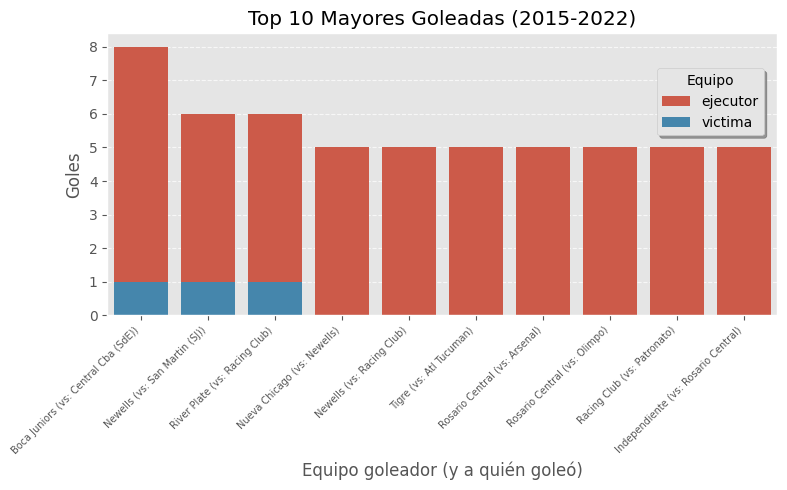

In [69]:
# Visualización mediante gráfico de barras agrupadas (Barplot)

f, (ax2) = plt.subplots(figsize=(8, 5), sharex=True)
aj = (sns.barplot(data = df_goleadosyvics, y ="goles", x = "match_identifier", hue="situacion", ax=ax2, dodge=False))

plt.title("Top 10 Mayores Goleadas (2015-2022)")
plt.ylabel("Goles")
plt.xlabel("Equipo goleador (y a quién goleó)")
plt.xticks(rotation= 45, ha="right", fontsize = 7)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend(title= "Equipo", loc="upper center", bbox_to_anchor=(0.9, 0.90),
          fancybox=True, shadow=True, ncol=1)
plt.show()

**Análisis de Eventos Críticos: Top 10 Mayores Goleadas**

Se destaca el encuentro de Boca Juniors (vs. Central Córdoba de Santiago del Estero) como el evento de mayor disparidad, alcanzando una cifra de 8 goles marcados frente a solo 1 recibido.

Aunque la liga presenta tendencias generales de paridad, existen escenarios específicos de desequilibrio total donde el "ejecutor" logra una efectividad ofensiva excepcional, usualmente concentrada en los equipos con plantillas de mayor valor de mercado o en momentos de crisis deportiva profunda de la "víctima".